# Exploración de Datos

### Importación del dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df= pd.read_csv("../Data/base-de-datos---enusc-2024.csv", sep=';', decimal=',')

df.head()


,Unnamed: 0,rph_ID,idhogar,enc_idr,enc_region,IH_residencia_habitual,IH_comparte_gastos,IH_numero_grupos,IH_cantidad_hogar,rph_numeroLinea,rph_numHogar,rph_parentesco,rph_edad,rph_sexo,Kish,Hogar_Kish,rph_idgen,rph_disc_a,rph_disc_b,rph_disc_c,rph_disc_d,rph_disc_e,rph_disc_f,rph_pertenencia_indigena,rph_lugar_nacimiento,rph_migracion,rph_nacionalidad,rph_nivel,rph_estadocivil,rph_situacion_laboral_a,rph_situacion_laboral_b,rph_categoria_ocupacional,rph_ciuo,rph_busqueda_empleo,rph_disponibilidad_trabajar,rph_razon_inactividad,rph_nse,rph_proveedor,P_AUMENTO_PAIS,P_AUMENTO_COM,...,RVI_INTENTO,RVI,RVI_AGREG,RPS_INTENTO,RPS,RPS_VIOLENTO,RPS_NO_VIOLENTO,RPS_KISH_VIOLENTO,HUR,FRB,EST,AGR,AMEN,AMEN_VIOLENTO,AMEN_KISH_VIOLENTO,EXT,EXT_VIOLENTO,EXT_KISH_VIOLENTO,SOB,HACK,VIRUS,BULLY,SUPLANT,RDV_REGION,RDDV_REGION,VANDVHC_REGION,RVI_REGION,RPS_REGION,HUR_REGION,AGR_REGION,AMEN_REGION,EXT_REGION,SOB_REGION,Fact_Pers_Reg,Fact_Hog_Reg,VarStrat,Conglomerado,com102,Fact_Hog_Regional_102,Fact_Pers_Regional_102
0,1,10001-1,10001-1,10001,8,1,NaN,NaN,1,1,1,1,7,2,1,1,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,2.0,4.0,2.0,2.0,NaN,NaN,2.0,2.0,4.0,1,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.898740,237.838487,2.024000e+09,2.024000e+13,1.0,260.552368,294.664390
1,2,10002-1,10002-1,10002,10,1,NaN,NaN,1,1,1,1,6,2,1,1,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,2.0,4.0,1.0,NaN,3.0,5.0,NaN,NaN,NaN,2,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.721281,183.351506,2.024000e+09,2.024000e+13,1.0,208.647186,228.040032
2,3,10003-1,10003-1,10003,8,2,1.0,NaN,1,1,1,1,6,2,1,1,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,2.0,3.0,1.0,NaN,3.0,5.0,NaN,NaN,NaN,2,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460.038821,242.024680,2.024000e+09,2.024000e+13,1.0,293.256301,595.433674
3,4,10003-2,10003-1,10003,8,2,1.0,NaN,1,2,1,3,2,2,0,1,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,3.0,5.0,2.0,2.0,NaN,NaN,1.0,1.0,NaN,2,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,10004-1,10004-1,10004,10,1,NaN,NaN,1,1,1,1,6,2,1,1,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,3.0,1.0,2.0,2.0,NaN,NaN,2.0,2.0,4.0,2,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.531255,183.126317,2.024000e+09,2.024000e+13,1.0,208.339870,227.704152


### Descripción Estadística de variables

Se observan que hay solo 2 variables categoricas, lo cual no tiene mucho sentido, ya que por ejemplo; 
los ids, las regiones, nível socioeconómico, entre muchas otras son variables categoricas (objeto).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70858 entries, 0 to 70857
Columns: 1314 entries, Unnamed: 0 to Fact_Pers_Regional_102
dtypes: float64(1299), int64(13), object(2)
memory usage: 710.4+ MB


In [4]:
# Calcular los cantidad de valores nulos: 
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

print("Top 20 columnas con más valores nulos:")
print(porcentaje_nulos.sort_values(ascending=False).head(20))

Top 20 columnas con más valores nulos:
VECINOS_ADOPTADAS_NA    100.000000
RFV_DONDE_COMUNA        100.000000
RFV_DONDE_REGION        100.000000
SOB_DENUNCIA_COMO       100.000000
SOB_SATISF_DEN          100.000000
SOB_CONTACTO_MP         100.000000
SOB_CONT_MP_MOT__1      100.000000
SOB_CONT_MP_MOT__88     100.000000
ADOPTADAS_NA            100.000000
SOB_CONT_MP_MOT__4      100.000000
VANDVIV_DONDE_REGION    100.000000
SOB_ACCION_POLICIAL     100.000000
SOB_CONT_MP_MOT__3      100.000000
SOB_CONT_MP_MOT__99     100.000000
SOB_DENUNCIAS_N         100.000000
SOB_CONT_MP_MOT__2      100.000000
SOB_CONT_MP_MOT__5      100.000000
SOB_DENUNCIA_FIRMA      100.000000
EXT_CONT_MP_MOT__2       99.998589
VANDVIV_DONDE_COMUNA     99.998589
dtype: float64


Un gran porcentaje de columnas con demasiados valores nulos, pero no es de extrañar, ya que existen preguntas que si se responden con un 'NO', entonces automáticamente se descartan una gran serie de preguntas subsiguientes. Resultando así en muchas columnas con valores nulos. 

In [5]:
columnas_nulas = sum(porcentaje_nulos > 50)
cant_columnas = len(df.columns)
print(f"Columnas con más del 50% de nulos: {columnas_nulas}")
print(f"Porcentaje de columnas con más de la mitad de datos nulos: {(columnas_nulas/cant_columnas) * 100:.3f}%")

Columnas con más del 50% de nulos: 1284
Porcentaje de columnas con más de la mitad de datos nulos: 97.717%


Dado que nuestro 'target' será VH_DMCS.

VH_DMCS (definición del pdf): 'Victimización a hogares por delitos de mayor connotación social  (Indicador de victimización histórico)'.

Es una variable binaria de dos clases: 
- 0: "No" -> el hogar no fue víctima.
- 1: "Sí" -> el hogar sí fue víctima. 

¿Por qué escogerlo como target? Porque responde directamente a la pregunta central de la encuesta: Entender qué factores se relacionan con el hecho de ser o no víctima. Con ésta variable como target, se buscará que el modelo pueda predecir la victimización. 

Una vez identificado el target, se puede realizar una limpieza relevante de datos, ya que ahora solo nos interesa el 'Informante Kish'. 

Informante Kish: Es la persona representante del hogar en la encuesta. 

Es ésta la persona de interés, ya que responde a si el hogar fue víctima de delito. 

In [6]:
# Filtramos el DF para quedarnos solo con el "Informante Kish"
df_informantes = df[df['Kish'] == 1].copy()

print(f"Filas originales (personas): {len(df)}")
print(f"Filas filtradas (informantes): {len(df_informantes)}")

Filas originales (personas): 70858
Filas filtradas (informantes): 24472


Se procede a lo comentado en un principio. Se mapean las variables que deberían ser categoricas. 

In [7]:
# Mapeo para nuestra variable objetivo: Victimización (VH_DMCS)
victima_labels = {
    0: 'No víctima',
    1: 'Sí'
}
df_informantes['victima_label'] = df_informantes['VH_DMCS'].map(victima_labels)

# Mapeo para Nivel Socioeconómico (rph_nse)
nse_labels = {
    1: 'NSE bajo',
    2: 'NSE medio',
    3: 'NSE alto'
}
df_informantes['nse_label'] = df_informantes['rph_nse'].map(nse_labels)

# Mapeo para Percepción en Barrio (P_AUMENTO_BARRIO)
percepcion_labels = {
    1: 'Aumentó',
    2: 'Se mantuvo',
    3: 'Disminuyó',
    88: 'No sabe',
    99: 'No responde'
}
df_informantes['percepcion_label'] = df_informantes['P_AUMENTO_BARRIO'].map(percepcion_labels)

# Mapeo para Tenencia de Rejas (MEDIDAS_REJAS)
rejas_labels = {
    0: 'No tiene rejas',
    1: 'Sí tiene rejas'
}
df_informantes['rejas_label'] = df_informantes['MEDIDAS_REJAS'].map(rejas_labels)

# Mapeo para Región (enc_region)
region_labels = {
    1: 'Tarapacá', 2: 'Antofagasta', 3: 'Atacama', 4: 'Coquimbo',
    5: 'Valparaíso', 6: "O'Higgins", 7: 'Maule', 8: 'Biobío',
    9: 'La Araucanía', 10: 'Los Lagos', 11: 'Aysén', 12: 'Magallanes',
    13: 'Metropolitana', 14: 'Los Ríos', 15: 'Arica y Parinacota', 16: 'Ñuble'
}
df_informantes['region_label'] = df_informantes['enc_region'].map(region_labels)

In [8]:
# Descripción de Variables Recodificadas 

print("--- Distribución Variable Objetivo (Victimización Hogar) ---")
# Usamos normalize=True para ver porcentajes
print(df_informantes['victima_label'].value_counts(normalize=True, dropna=False) * 100)

print("\n--- Distribución Muestra por Región ---")
print(df_informantes['region_label'].value_counts(dropna=False))

print("\n--- Distribución Muestra por NSE ---")
print(df_informantes['nse_label'].value_counts(dropna=False))

print("\n--- Distribución Percepción Delincuencia Barrio ---")
print(df_informantes['percepcion_label'].value_counts(dropna=False))

--- Distribución Variable Objetivo (Victimización Hogar) ---
victima_label
No víctima    78.931023
Sí            21.068977
Name: proportion, dtype: float64

--- Distribución Muestra por Región ---
region_label
Metropolitana         5431
Valparaíso            2457
Biobío                1679
Maule                 1368
O'Higgins             1269
Los Lagos             1226
Antofagasta           1208
Arica y Parinacota    1207
Tarapacá              1203
La Araucanía          1198
Coquimbo              1168
Magallanes            1159
Ñuble                 1121
Los Ríos              1104
Atacama                848
Aysén                  826
Name: count, dtype: int64

--- Distribución Muestra por NSE ---
nse_label
NSE bajo     10429
NSE medio     9875
NSE alto      4168
Name: count, dtype: int64

--- Distribución Percepción Delincuencia Barrio ---
percepcion_label
Aumentó        11550
Se mantuvo     10888
Disminuyó       1559
No sabe          459
No responde       16
Name: count, dtype: int64


In [9]:
# Descripción de Variables Numéricas Reales
print("--- Estadísticas de Factores de Expansión (Numéricas) ---")
numeric_cols = ['Fact_Pers_Reg', 'Fact_Hog_Reg', 'Fact_Hog_Regional_102', 'Fact_Pers_Regional_102']
    
print(df_informantes[numeric_cols].describe())


--- Estadísticas de Factores de Expansión (Numéricas) ---
       Fact_Pers_Reg  ...  Fact_Pers_Regional_102
count   24472.000000  ...            22273.000000
mean      539.001798  ...              654.150855
std       553.276615  ...              587.034488
min        31.714986  ...               37.275216
25%       203.436389  ...              268.570935
50%       375.629189  ...              504.163800
75%       668.170242  ...              850.742700
max     10393.711595  ...             9519.351092

[8 rows x 4 columns]


In [10]:
# Para columnas que sean de tipo 'objeto'/categoricas
# Los dos ids + las 5 columnas categoricas que se corrigieron
df_informantes.describe(include='object')

,rph_ID,idhogar,victima_label,nse_label,percepcion_label,rejas_label,region_label
count,24472,24472,24472,24472,24472,24472,24472
unique,24472,24472,2,3,5,2,16
top,10001-1,10001-1,No víctima,NSE bajo,Aumentó,No tiene rejas,Metropolitana
freq,1,1,19316,10429,11550,13088,5431


Ahora se comienza a crear "mini tablas" con datos importantes y sus respectivos gráficos. 

Conteo:
vh_dmcs_label
No víctima    19316
Sí             5156
Name: count, dtype: int64


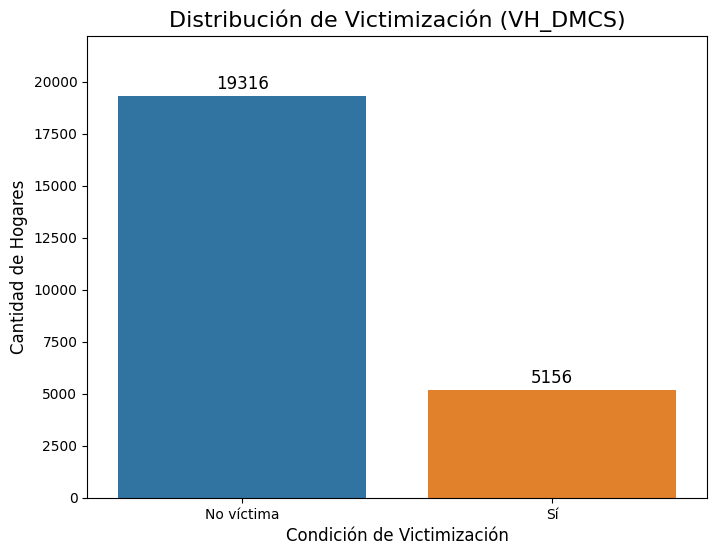

In [11]:
df_informantes['vh_dmcs_label'] = df_informantes['VH_DMCS'].map(victima_labels)

plt.figure(figsize=(8, 6)) 
ax = sns.countplot(
    x='vh_dmcs_label',
    hue='vh_dmcs_label',
    data=df_informantes,
    order=['No víctima', 'Sí'],
    legend=False
)

ax.set_title('Distribución de Victimización (VH_DMCS)', fontsize=16)
ax.set_xlabel('Condición de Victimización', fontsize=12)
ax.set_ylabel('Cantidad de Hogares', fontsize=12)

# Añade el conteo sobre cada barra
counts = df_informantes['vh_dmcs_label'].value_counts().reindex(['No víctima', 'Sí'])

# Asignamos las alturas correctas
ax.patches[0].set_height(counts.get('No víctima', 0))
ax.patches[1].set_height(counts.get('Sí', 0))

# Ajustamos el límite Y
ax.set_ylim(0, counts.max() * 1.15) # Da espacio para la etiqueta
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', # El número a mostrar (como entero)
                (p.get_x() + p.get_width() / 2., p.get_height()), # Posición
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12)

print("Conteo:")
print(counts)

In [12]:
# Agrupamos por la etiqueta de NSE y calculamos la media de VH_DMCS.
# Multiplicamos por 100 para obtener el porcentaje.
tasa_victim_nse = df_informantes.groupby('nse_label')['VH_DMCS'].mean() * 100

# 4. Imprime la tabla
print("--- Tasa de Victimización (VH_DMCS=1) por Nivel Socioeconómico ---")
print(tasa_victim_nse.to_string(float_format='{:.1f}%'.format))

--- Tasa de Victimización (VH_DMCS=1) por Nivel Socioeconómico ---
nse_label
NSE alto    24.5%
NSE bajo    18.8%
NSE medio   22.0%


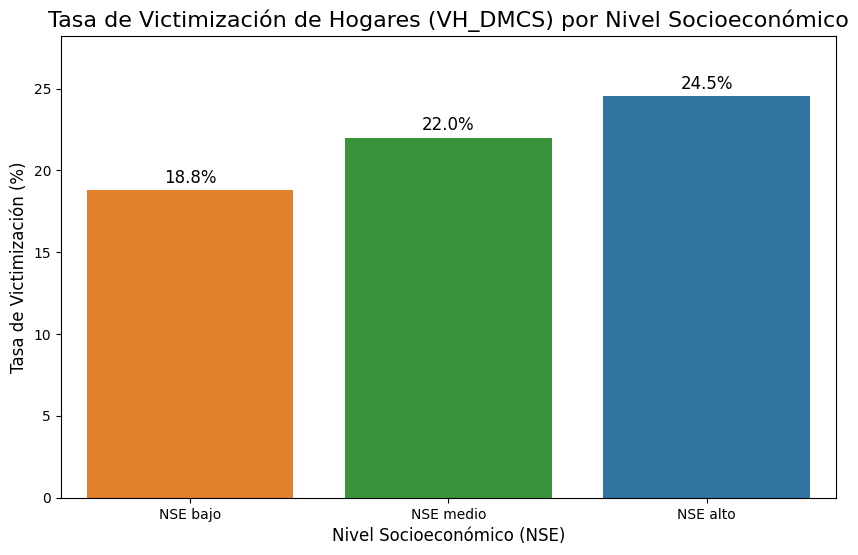

In [13]:
df_plot = tasa_victim_nse.reset_index(name='Tasa de Victimización (%)')

# Dibujar el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='nse_label',
    y='Tasa de Victimización (%)',
    hue='nse_label', # Necesario para evitar el warning de 'palette'
    data=df_plot,
    order=['NSE bajo', 'NSE medio', 'NSE alto'],
    legend=False 
)

ax.set_title('Tasa de Victimización de Hogares (VH_DMCS) por Nivel Socioeconómico', fontsize=16)
ax.set_xlabel('Nivel Socioeconómico (NSE)', fontsize=12)
ax.set_ylabel('Tasa de Victimización (%)', fontsize=12)
ax.set_ylim(0, df_plot['Tasa de Victimización (%)'].max() * 1.15) # Da espacio arriba

#  Añade las etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', # Formato con 1 decimal
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12)

In [14]:
# Agrupar y Calcular (y ordenar de mayor a menor)
tasa_victim_region = df_informantes.groupby('region_label')['VH_DMCS'].mean().sort_values(ascending=False) * 100

# Imprimir Tabla
print(tasa_victim_region.to_string(float_format='{:.1f}%'.format))

region_label
Tarapacá             34.0%
Arica y Parinacota   29.4%
Metropolitana        28.4%
Valparaíso           24.6%
O'Higgins            21.4%
Los Ríos             18.5%
Coquimbo             18.2%
Biobío               18.2%
Antofagasta          17.7%
Ñuble                17.2%
La Araucanía         15.9%
Los Lagos            15.7%
Maule                15.1%
Atacama              14.9%
Magallanes            7.1%
Aysén                 5.9%


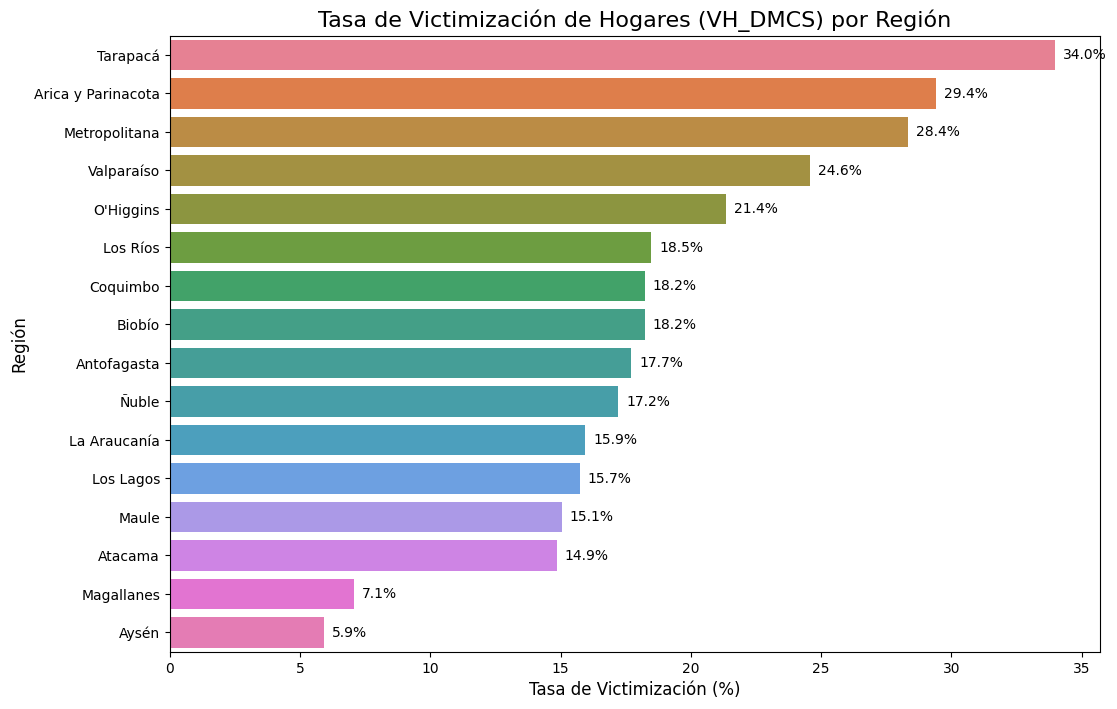

In [15]:
# Preparar datos para el gráfico
df_plot_b = tasa_victim_region.reset_index(name='Tasa de Victimización (%)')

# Graficar (Horizontal es mejor para 16 categorías)
plt.figure(figsize=(12, 8))
ax_b = sns.barplot(
    x='Tasa de Victimización (%)',
    y='region_label',
    hue='region_label', # Asigna hue para colorear
    data=df_plot_b,
    dodge=False # Evita que las barras se separen
)

ax_b.set_title('Tasa de Victimización de Hogares (VH_DMCS) por Región', fontsize=16)
ax_b.set_xlabel('Tasa de Victimización (%)', fontsize=12)
ax_b.set_ylabel('Región', fontsize=12)

# Anotar barras horizontales
for p in ax_b.patches:
    ax_b.annotate(f'{p.get_width():.1f}%', 
                  (p.get_width() + 0.3, p.get_y() + p.get_height() / 2),
                  ha='left', va='center', fontsize=10)


In [16]:
# .dropna() elimina las filas que no mapeamos (ej. 88 y 99)
tasa_victim_percep = df_informantes.dropna(subset=['percepcion_label']).groupby('percepcion_label')['VH_DMCS'].mean() * 100

# Imprimir Tabla
print(tasa_victim_percep.to_string(float_format='{:.1f}%'.format))



percepcion_label
Aumentó       27.5%
Disminuyó     14.2%
No responde   18.8%
No sabe       15.9%
Se mantuvo    15.4%


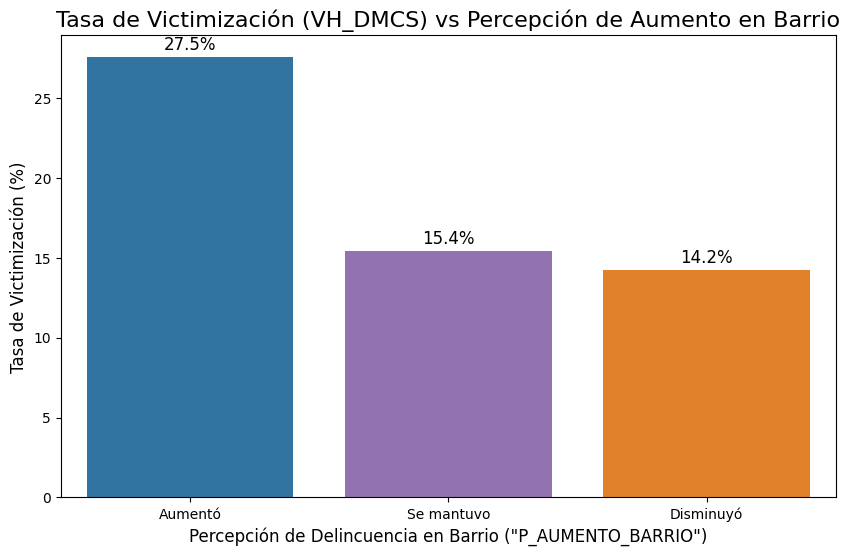

In [17]:
# Preparar datos para el gráfico
df_plot_c = tasa_victim_percep.reset_index(name='Tasa de Victimización (%)')

# Graficar 
plt.figure(figsize=(10, 6))
ax_c = sns.barplot(
    x='percepcion_label',
    y='Tasa de Victimización (%)',
    hue='percepcion_label', # Asigna hue para colorear
    data=df_plot_c,
    order=['Aumentó', 'Se mantuvo', 'Disminuyó'], # Orden lógico
    dodge=False
)

ax_c.set_title('Tasa de Victimización (VH_DMCS) vs Percepción de Aumento en Barrio', fontsize=16)
ax_c.set_xlabel('Percepción de Delincuencia en Barrio ("P_AUMENTO_BARRIO")', fontsize=12)
ax_c.set_ylabel('Tasa de Victimización (%)', fontsize=12)

# Anotar barras verticales
for p in ax_c.patches:
    ax_c.annotate(f'{p.get_height():.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)


In [18]:
tasa_victim_rejas = df_informantes.groupby('rejas_label')['VH_DMCS'].mean() * 100

# Imprimir Tabla
print(tasa_victim_rejas.to_string(float_format='{:.1f}%'.format))

rejas_label
No tiene rejas   18.7%
Sí tiene rejas   23.8%


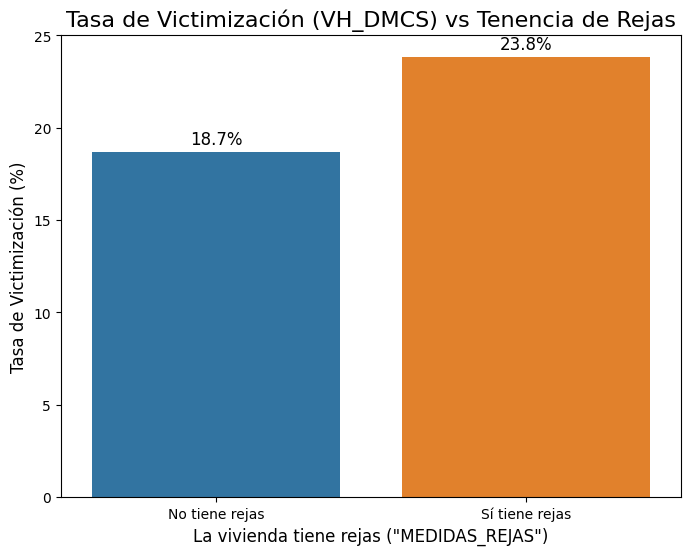

In [19]:
df_plot_d = tasa_victim_rejas.reset_index(name='Tasa de Victimización (%)')

# Graficar 
plt.figure(figsize=(8, 6))
ax_d = sns.barplot(
    x='rejas_label',
    y='Tasa de Victimización (%)',
    hue='rejas_label', # Asigna hue para colorear
    data=df_plot_d,
    order=['No tiene rejas', 'Sí tiene rejas'],
    dodge=False
)

ax_d.set_title('Tasa de Victimización (VH_DMCS) vs Tenencia de Rejas', fontsize=16)
ax_d.set_xlabel('La vivienda tiene rejas ("MEDIDAS_REJAS")', fontsize=12)
ax_d.set_ylabel('Tasa de Victimización (%)', fontsize=12)

# Anotar barras verticales
for p in ax_d.patches:
    ax_d.annotate(f'{p.get_height():.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)

### Identificación de características relevantes, correlaciones y distribuciones de datos.

In [ ]:
def drop_victimization_features(df, target_variable='VH_DMCS'):
    # Prefijos asociados a la sección de victimización
    victimization_prefixes = [
        'SCREEN_', 'RDV_', 'RDDV_', 'VANDVHC_', 'RFV_', 'VANDVIV_', 'RVI_',
        'RPS_', 'HUR_', 'FRB_', 'EST_', 'AGR_', 'AMEN_', 'EXT_', 'SOB_',
        'HACK_', 'VIRUS_', 'BULLY_', 'SUPLANT_', 'ACOSO_', 
        'VH_', 'VH_DC', 'RDDV', 'HUR', 'VH_DV', 'RFV', 'RPS', 
        'VP', 'RVI', 'AGR', 'RDV', 'VH_IR', 'RVH', 'FILTRO_VEHIC', 'COSC',
        'DEN_', 'Kish', 'Hogar_Kish', 'Conglomerado', 'Varstrat', 'Fact_'
    ]
    
    cols_to_drop = []
    for col in df.columns:
        # Solo borra la columna si no es el target y empieza con un prefijo
        if col != target_variable and any(col.startswith(p) for p in victimization_prefixes):
            cols_to_drop.append(col)
    
    print(f"Se eliminarán {len(cols_to_drop)} columnas (se conserva el target '{target_variable}').")
    return df.drop(columns=cols_to_drop, errors='ignore')

df_clean = drop_victimization_features(df_informantes, target_variable='VH_DMCS')

df_clean.info()

Se eliminarán 1104 columnas (se conserva el target 'VH_DMCS').
<class 'pandas.core.frame.DataFrame'>
Index: 24472 entries, 0 to 70854
Columns: 216 entries, Unnamed: 0 to vh_dmcs_label
dtypes: float64(197), int64(11), object(8)
memory usage: 40.5+ MB


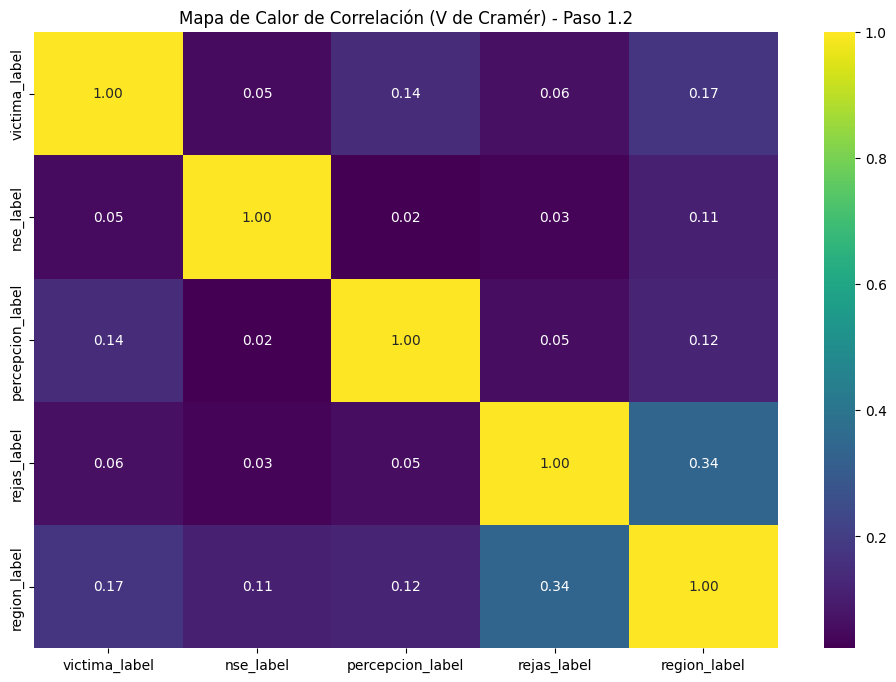

In [ ]:
from scipy.stats import chi2_contingency

features_para_correlacion = [
    'victima_label',   # Nuestro target
    'nse_label',
    'percepcion_label',
    'rejas_label',
    'region_label'
]

df_corr = df_informantes[features_para_correlacion].copy()

# Limpieza (Imputación de Nulos para la prueba) ---
#    Chi2 no funciona con NaNs (como los "No sabe")
#    Los llenamos con la moda (el valor más común)
for col in df_corr.columns:
    moda = df_corr[col].mode()[0]
    df_corr[col] = df_corr[col].fillna(moda)
    # También reemplazamos 'No sabe' o 'No responde' si existen
    df_corr[col] = df_corr[col].replace(['No sabe', 'No responde'], moda)


# Función para calcular V de Cramér 
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Calcular la matriz de correlación (V de Cramér) 
cols = df_corr.columns
corr_matrix_cramer = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        corr_matrix_cramer.loc[col1, col2] = cramers_v(df_corr[col1], df_corr[col2])

# Convertir a numérico para el heatmap
corr_matrix_cramer = corr_matrix_cramer.astype(float)

# --- 5. Visualizar el Heatmap (Punto 1.3) ---
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_cramer, annot=True, fmt='.2f', cmap='viridis')
plt.title('Mapa de Calor de Correlación (V de Cramér) - Paso 1.2')
plt.show()

### Visualización de variables importantes


# Selección de Características

# Desarrollo de Modelo Supervisado
Como se deben escoger dos modelos, hemos decidido aplicar Regresión Logística y Random Forest.
Con ello probamos dos enfoques fundamentalmente diferentes. Un Lineal vs un No-Lineal.

In [48]:
from sklearn.model_selection import train_test_split

df_modelos = df_clean

y = df_modelos['VH_DMCS']
X = df_modelos.select_dtypes(include=['int64', 'float64'])
X = X.drop(columns=['VH_DMCS', 'Unnamed: 0'], errors='ignore')

print(f"Forma final de X (solo features int/float): {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Forma final de X (solo features int/float): (24472, 206)


Se hará uso de Pipelines, ya que tienen una serie de ventajas como manejar la imputación (rellenar "No sabe") y la codificación (convertir texto a números) de forma correcta, evitando fugas de datos.

Componentes de un Pipeline: 
- Transformadores: Preparación de datos a través de diferentes operaciones
  - Escalado de características con StandardScaler.
  - Imputación de valores faltantes con SimpleImputer.
  - Codificación de variables categóricas con OneHotEncoder.
- Estimador final: El modelo que realiza la clasificación, que para nuestro caso será LogisticRegression y RandomForestClassifier.

## Regresión Logística
Lo usaremos como un modelo base para la clasificación. Tiene la ventaja que es rapido de entrenar y altamente interpretable (porque es lineal). 

Modelo 1: Regresión Logística



/home/marcosmartinez/Semestre_VI/AI/tarea_2_ia/.venv/lib64/python3.14/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['ADOPTADAS_NA' 'VECINOS_ADOPTADAS_NA']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/marcosmartinez/Semestre_VI/AI/tarea_2_ia/.venv/lib64/python3.14/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['ADOPTADAS_NA' 'VECINOS_ADOPTADAS_NA']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


                precision    recall  f1-score   support

No víctima (0)       0.86      0.76      0.81      5795
        Sí (1)       0.38      0.54      0.44      1547

      accuracy                           0.72      7342
     macro avg       0.62      0.65      0.63      7342
  weighted avg       0.76      0.72      0.73      7342

Matriz de Confusión (Regresión Logística):


/home/marcosmartinez/Semestre_VI/AI/tarea_2_ia/.venv/lib64/python3.14/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['ADOPTADAS_NA' 'VECINOS_ADOPTADAS_NA']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


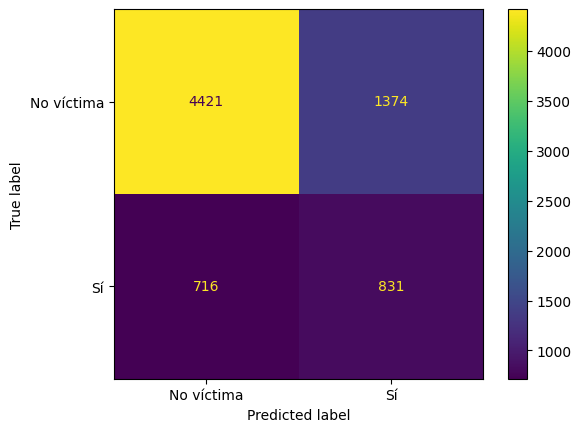

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Definimos 2 transformadores 
numeric_features = ['rph_edad', 'IH_residencia_habitual']
categorical_features = [
    col for col in X_train.columns 
    if col not in numeric_features
]

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Rellenar edad si falta
    ('scaler', StandardScaler()) # Escalar
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Rellenar "No sabe" con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Convertir a dummies
])

# Combinar transformadores
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Crear el Pipeline Para LogisticRegression
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(
        class_weight='balanced', 
        random_state=42,
        max_iter=1000
    ))
])

# Entrenar y Evaluar
print("Modelo 1: Regresión Logística\n")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# Mostrar Reporte de Clasificación
print(classification_report(y_test, y_pred_lr, target_names=['No víctima (0)', 'Sí (1)']))

# Mostrar Matriz de Confusión
print("Matriz de Confusión (Regresión Logística):")
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, display_labels=['No víctima', 'Sí'])
plt.show()

## Random Forest
Nuestro segundo modelo es uno no lineal. Su ventaja sobre la Regresión Logística es que puede capturar relaciones más complejas entre las variables. Es un modelo con la fama de ser robusto y una baja propensión al overfitting. 

Modelo 2: Random Forest



/home/marcosmartinez/Semestre_VI/AI/tarea_2_ia/.venv/lib64/python3.14/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['ADOPTADAS_NA' 'VECINOS_ADOPTADAS_NA']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/marcosmartinez/Semestre_VI/AI/tarea_2_ia/.venv/lib64/python3.14/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['ADOPTADAS_NA' 'VECINOS_ADOPTADAS_NA']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


                precision    recall  f1-score   support

No víctima (0)       0.79      1.00      0.88      5795
        Sí (1)       0.63      0.01      0.02      1547

      accuracy                           0.79      7342
     macro avg       0.71      0.50      0.45      7342
  weighted avg       0.76      0.79      0.70      7342

Matriz de Confusión (Random Forest):


/home/marcosmartinez/Semestre_VI/AI/tarea_2_ia/.venv/lib64/python3.14/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['ADOPTADAS_NA' 'VECINOS_ADOPTADAS_NA']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


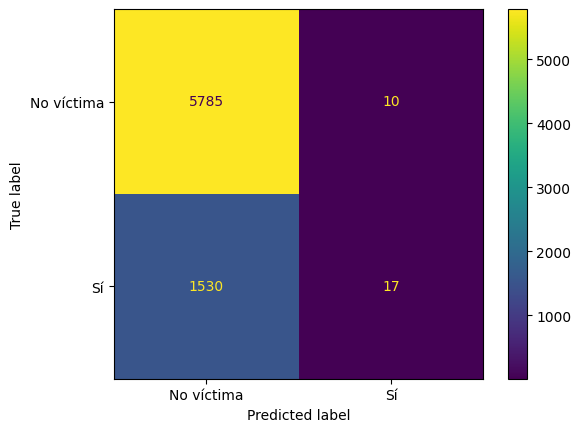

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Ocupamos los mismos transformadores
# Numérico (solo imputar, no necesita escalar)
numeric_transformer_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categórico (Usamos OrdinalEncoder, que es mejor para árboles)
categorical_transformer_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combinar
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_rf, numeric_features),
        ('cat', categorical_transformer_rf, categorical_features)
    ],
    remainder='drop'
)

# Crear el Pipeline para RandomForest
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced', 
        random_state=42
    ))
])

# Entrenar y Evaluar 
print("Modelo 2: Random Forest\n")
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

# Mostrar Reporte de Clasificación
print(classification_report(y_test, y_pred_rf, target_names=['No víctima (0)', 'Sí (1)']))

# Mostrar Matriz de Confusión
print("Matriz de Confusión (Random Forest):")
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test, display_labels=['No víctima', 'Sí'])
plt.show()

# Evaluación de sesgo y varianza

# Resultados y Conclusiones